# Diffusion forward process

In this notebook we define the forward process for diffusion using our predefined transformer model.

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

In [2]:
# Load a default model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Embedding matrix

From the paper:

> We define the embedding of a sequence $w$ of length $n$ to be:
> $$\textrm{EMB}(w) = [\textrm{EMB}(w_1), ..., \textrm{EMB}(w_n)] \in \mathbb{R}^{nd}$$

So we calculate the embeddings for each token, and stack those to form the embedding matrix $w$.

In [6]:
example_text = "In a hole in the ground there lived a hobbit"
encoded_input = tokenizer(example_text, return_tensors="pt")["input_ids"]
output = model(encoded_input)
embeddings = output["last_hidden_state"]

In [14]:
# Show individual tokens
" ".join(tokenizer.convert_ids_to_tokens(encoded_input[0]))

'[CLS] in a hole in the ground there lived a ho ##bb ##it [SEP]'

In [18]:
# Show the embeddings
print(embeddings.shape)
embeddings

torch.Size([1, 14, 768])


tensor([[[-0.1430,  0.2258, -0.2769,  ..., -0.2089,  0.2554,  0.3328],
         [-0.3623,  0.3898, -0.5615,  ..., -0.3843,  0.2713,  0.2537],
         [-0.1815,  0.0819, -0.1862,  ..., -0.3564,  0.1374,  0.5064],
         ...,
         [-0.4391, -0.2379,  0.2243,  ...,  0.5124, -0.2932,  0.3388],
         [-0.2497, -0.5978, -0.6163,  ...,  0.2687, -0.0632,  0.5896],
         [ 0.7250,  0.2462, -0.4129,  ..., -0.0941, -0.5447, -0.3513]]],
       grad_fn=<NativeLayerNormBackward0>)

### Diffusion noise schedule

In the paper, they use a square root noise schedule defined by:
$$\bar{\alpha}_t = 1 - \sqrt{t/T + s}$$
where $s$ is a small constant that corresponds to the starting noise level, chosen to be 1e-4 and $T$ is the total number of noise steps, set to 2000.

The noise level at time step t, $\sigma_t$ is then calculated as $\sigma_t=\sqrt{1-\bar{\alpha}_t}$.

In [220]:
def diffusion_noise_schedule(t, T=2000, s=1e-4):
    alpha = 1 - np.sqrt(t / T + s)
    return np.sqrt(1 - alpha)

Text(0.5, 1.0, 'Diffusion noise schedule')

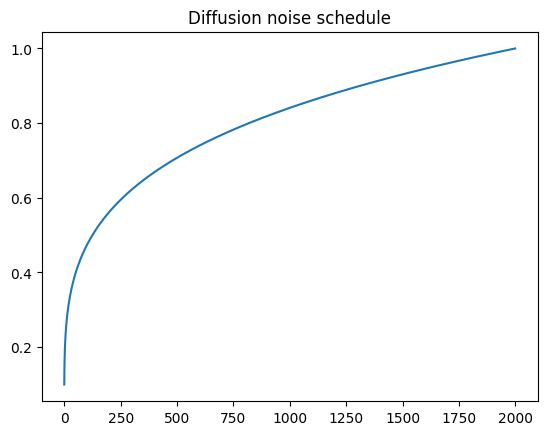

In [221]:
betas = diffusion_noise_schedule(np.arange(2000))
plt.plot(betas)
plt.title("Diffusion noise schedule")

### Markov transition

From the paper:
> Our approach adds a Markov transition from discrete words $w$ to $x_0$ in the forward process, parametrized by $q_0(x_0|w) = \mathcal{N}(\textrm{EMB}(w), \sigma_0 I)$

In [97]:
x_0 = embeddings[0, 0, :]

In [98]:
sigma = diffusion_noise_schedule(0)
q_0 = torch.normal(mean=x_0, std=sigma)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          2.,   0.,   2.,   1.,   0.,   2.,   4.,  64., 345., 299.,  41.,
          4.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-7.85179186, -7.45616102, -7.06053019, -6.66489935, -6.26926851,
        -5.8736372 , -5.47800636, -5.08237553, -4.68674469, -4.29111385,
        -3.89548302, -3.49985218, -3.10422134, -2.70859027, -2.31295943,
        -1.9173286 , -1.52169776, -1.1260668 , -0.73043597, -0.33480507,
         0.06082582,  0.45645672,  0.85208762,  1.24771845,  1.64334941,
         2.03898025,  2.43461108,  2.83024192,  3.22587299,  3.62150383,
         4.01713467]),
 <BarContainer object of 30 artists>)

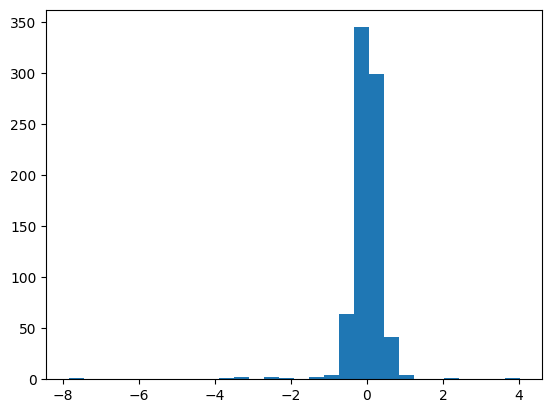

In [192]:
plt.hist(x_0.detach().numpy(), bins=30)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          2.,   0.,   1.,   2.,   0.,   0.,   8.,  52., 327., 301.,  68.,
          3.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-7.93654871, -7.53872013, -7.14089155, -6.74306345, -6.34523487,
        -5.94740629, -5.54957771, -5.15174961, -4.75392103, -4.35609245,
        -3.95826411, -3.56043553, -3.16260719, -2.76477861, -2.36695027,
        -1.96912169, -1.57129323, -1.17346478, -0.77563632, -0.37780783,
         0.02002064,  0.41784912,  0.81567758,  1.2135061 ,  1.61133456,
         2.0091629 ,  2.40699148,  2.80481982,  3.2026484 ,  3.60047674,
         3.99830532]),
 <BarContainer object of 30 artists>)

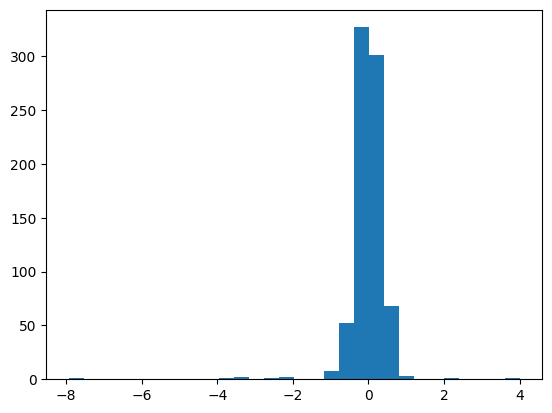

In [190]:
plt.hist(q_0.detach().numpy(), bins=30)

(array([ 1.,  0.,  0.,  2.,  3.,  4., 11., 10., 16., 18., 31., 57., 65.,
        52., 70., 78., 89., 66., 61., 38., 34., 22., 24.,  7.,  4.,  0.,
         1.,  1.,  2.,  1.]),
 array([-0.3691555 , -0.34487188, -0.32058823, -0.29630461, -0.272021  ,
        -0.24773736, -0.22345373, -0.19917011, -0.17488648, -0.15060286,
        -0.12631923, -0.1020356 , -0.07775198, -0.05346835, -0.02918472,
        -0.0049011 ,  0.01938253,  0.04366616,  0.06794979,  0.09223341,
         0.11651704,  0.14080067,  0.16508429,  0.18936792,  0.21365154,
         0.23793517,  0.2622188 ,  0.28650242,  0.31078604,  0.33506969,
         0.3593533 ]),
 <BarContainer object of 30 artists>)

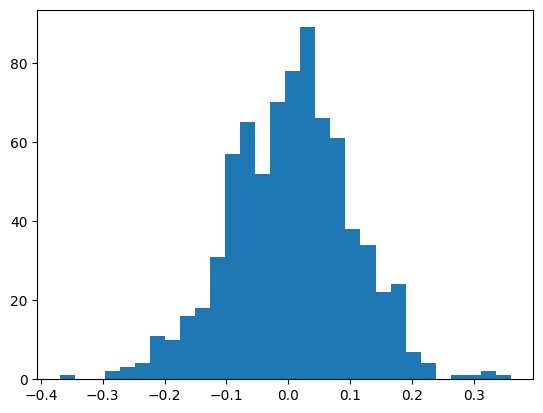

In [100]:
plt.hist(x_0.detach().numpy() - q_0.detach().numpy(), bins=30)

### Rounding step

In the reverse process, they added a trainable rounding step, parametrized by:
$$p_\theta(w | x_0) = \prod_{i=1}^n p_\theta(w_i | x_i)$$
where $p_\theta(w_i|x_i)$ is a softmax distribution.

In [139]:
# Word embeddings matrix - we do knn on this:
embeddings = model.embeddings.word_embeddings.weight
embeddings

Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       requires_grad=True)

In [140]:
embeddings.shape

torch.Size([30522, 768])

### Softmax

We compute a softmax over the similarity between `x_0` and the word embeddings to get a probability over the tokens:

In [171]:
x_0.shape, embeddings.shape

(torch.Size([768]), torch.Size([30522, 768]))

In [186]:
# Compute l2 similarity
l2_dist = torch.cdist(x_0.reshape(1, x_0.shape[0]), embeddings)

# Convert to probabilities
token_prob = torch.nn.Softmax(dim=1)(l2_dist)
token_prob

tensor([[3.2664e-05, 3.2669e-05, 3.2711e-05,  ..., 3.1543e-05, 3.2007e-05,
         3.4675e-05]], grad_fn=<SoftmaxBackward0>)

We use K-nearest neighbours to find the closest token to the given embedding $x_0$ as shown below:

In [166]:
dist = torch.norm(embeddings - x_0, dim=1, p=2)
values, indices = dist.topk(3, largest=False)
knn_tokens = [tokenizer.ids_to_tokens[int(ix)] for ix in indices]

print(f"Nearest tokens are: {indices.tolist()} - {knn_tokens}")

Nearest tokens are: [101, 3023, 2007] - ['[CLS]', 'coast', 'with']


### Training objective

The training objective used in the paper is given below:

$$\mathcal{L}_{\textrm{simple}}^{\textrm{e2e}}(w) = \mathbb{E}_{q_\phi(x_{0:T}|w)}\left[\mathcal{L}_{\textrm{simple}}(x_0) + \|\textrm{EMB}(w)-\mu_\theta(x_1,1)\|^2 - \log p_\theta(w|x_0) \right]$$

where $\mathcal{L}_{\textrm{simple}}$ is given by:
$$\mathcal{L}_{\textrm{simple}} = \sum_{t=1}^T \mathbb{E}_{q(x_t|x_0)} \|\mu_\theta(x_t,t)\ - \hat{\mu}(x_t,x_0)\|$$
